**About** : This notebook is used to infer models.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ../src/

/home/tviel/work/kaggle_birdclef_2024/src


/home/tviel/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Imports

In [4]:
import os
import gc
import sys
import cv2
import glob
import json
import torch
import shutil
import librosa
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from joblib import Parallel, delayed

In [5]:
from util.logger import Config
from util.metrics import macro_auc
from util.torch import load_model_weights

from data.dataset import WaveInfDataset
from data.preparation import prepare_data, prepare_folds
from data.processing import create_target_path, ProgressParallel, get_load_librosa_save_h5py

from model_zoo.models import define_model
from inference.predict import predict

from params import CLASSES

/home/tviel/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Params

In [6]:
EVAL = False

In [7]:
if EVAL:
    DATA_PATH = "../input/train_audio/"
else:
    DATA_PATH = "../input/unlabeled_soundscapes/"

In [8]:
BATCH_SIZE = 32
USE_FP16 = True
NUM_WORKERS = 2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu" 

DURATION = 5
SR = 32000

In [11]:
FOLD = 0 if EVAL else "fullfit_0"

EXP_FOLDERS = [
    # ("../logs/2024-04-12/8/", [FOLD]),   # LB 0.64 baseline
    # ("../logs/2024-04-18/12/", [FOLD]),  #
    # ("../logs/2024-04-18/15/", [FOLD]),  #
    # ("../logs/2024-04-19/4/", [FOLD]),  # Change norm, sampling
    # ("../logs/2024-04-19/5/", [FOLD]),  # d=15s
    # ("../logs/2024-04-19/7/", [FOLD]),  # minmaxnorm, sampling, nocall, less mix
    # ("../logs/2024-04-19/8/", [FOLD]),  # minmaxnorm, no sampling, nocall, less mix no add
    # ("../logs/2024-04-19/10/", [FOLD]),  # minmaxnorm more mix more aug
    # ("../logs/2024-04-29/2/", [FOLD]),  # minmaxnorm fixed crop
    # ("../logs/2024-04-29/4/", [FOLD]),  # minmaxnorm fixed crop 20s selfmix
    # ("../logs/2024-04-29/6/", [FOLD]),  # minmaxnorm fixed crop no_xc selfmix
    # ("../logs/2024-04-29/7/", [FOLD]),  # minmaxnorm fixed crop no_xc selfmix focal_bce ousmk
    # ("../logs/2024-04-30/0/", [FOLD]),  # minmaxnorm selfmix focal_bce ousmk
    # ("../logs/2024-04-30/1/", [FOLD]),  # minmaxnorm selfmix focal_bce ousmk++
    # ("../logs/2024-04-30/3/", [FOLD]),  # minmaxnorm selfmix focal_bce no_xc more mix
    # ("../logs/2024-04-30/4/", [FOLD]),  # minmaxnorm selfmix bce no_xc ousmk^
    # ("../logs/2024-05-02/0/", [FOLD]),  # selfmix focal_bce ousmk + dedup, new melspec params, start-end sampling
    # ("../logs/2024-05-02/15/", [FOLD]),  # no selfmix focal_bce ousmk + 2nd mask, new melspec params, start-end sampling
    # ("../logs/2024-05-02/15/", [FOLD]),  # no selfmix focal_bce ousmk + 2nd mask, new melspec params, start-end sampling
    ("../logs/2024-05-03/7/", [FOLD]),  # no selfmix focal_bce ousmk + 2nd mask, new melspec params, start-end sampling DEDUP UPSAMPLE
]

In [12]:
from util.logger import upload_to_kaggle

upload_to_kaggle(
    [f for f, _ in EXP_FOLDERS],
    directory="../output/dataset_1/",
    dataset_name="BirdCLEF 2024 Weights 1",
    update_folders=True
)

- Copying ../logs/2024-05-03/7/ ...

Dataset size : 3.098 Go
- Update existing dataset !
- Uploading ...


100%|██████████| 72.9M/72.9M [00:02<00:00, 29.6MB/s]
100%|██████████| 371M/371M [00:11<00:00, 34.9MB/s] 
100%|██████████| 539k/539k [00:00<00:00, 639kB/s]
100%|██████████| 371M/371M [00:11<00:00, 35.1MB/s] 
100%|██████████| 72.9M/72.9M [00:02<00:00, 29.5MB/s]
100%|██████████| 372M/372M [00:11<00:00, 35.2MB/s] 
100%|██████████| 72.9M/72.9M [00:02<00:00, 29.8MB/s]
100%|██████████| 372M/372M [00:11<00:00, 35.1MB/s] 
100%|██████████| 372M/372M [00:11<00:00, 35.1MB/s] 
100%|██████████| 371M/371M [00:11<00:00, 32.7MB/s] 
100%|██████████| 72.9M/72.9M [00:02<00:00, 29.7MB/s]
100%|██████████| 372M/372M [00:11<00:00, 35.1MB/s] 



Output :
 b"Starting upload for file 2024-04-30_0.zip\nWarning: Looks like you're using an outdated API Version, please consider updating (server 1.6.12 / client 1.6.8)\nUpload successful: 2024-04-30_0.zip (73MB)\nStarting upload for file 2024-04-29_7.zip\nUpload successful: 2024-04-29_7.zip (371MB)\nStarting upload for file folds_4.csv\nUpload successful: folds_4.csv (539KB)\nStarting upload for file 2024-04-29_6.zip\nUpload successful: 2024-04-29_6.zip (371MB)\nStarting upload for file 2024-04-30_4.zip\nUpload successful: 2024-04-30_4.zip (73MB)\nStarting upload for file 2024-05-02_15.zip\nUpload successful: 2024-05-02_15.zip (372MB)\nStarting upload for file 2024-04-30_3.zip\nUpload successful: 2024-04-30_3.zip (73MB)\nStarting upload for file 2024-05-03_7.zip\nUpload successful: 2024-05-03_7.zip (372MB)\nStarting upload for file 2024-04-29_4.zip\nUpload successful: 2024-04-29_4.zip (372MB)\nStarting upload for file 2024-05-02_0.zip\nUpload successful: 2024-05-02_0.zip (371MB)\nSta

### Preprocessing

In [131]:
if EVAL:
    df = pd.DataFrame({"path": glob.glob(DATA_PATH + "*/*")})
    df["id"] = df["path"].apply(lambda x: x.split("/")[-1][:-4])

    folds = pd.read_csv('../input/folds_4.csv')
    folds['id'] = folds['filename'].apply(lambda x: x.split('/')[-1][:-4])
    df = df.merge(folds)
    df = df[df['fold'] == 0].reset_index(drop=True)

    df["primary_label"] = df["path"].apply(lambda x:  x.split('/')[-2])
else:
    df = pd.DataFrame({"path": glob.glob(DATA_PATH + "*")})
    df["id"] = df["path"].apply(lambda x: x.split("/")[-1][:-4])

df["duration"] = df["path"].apply(lambda x: librosa.get_duration(path=x))

df['slice'] = df['duration'].apply(lambda x: [(DURATION * i * SR, DURATION * (i + 1) * SR) for i in range(int(np.ceil(x / DURATION)))])
df = df.explode("slice")

df["t_end"] = DURATION
df['t_end'] = df[["id", "t_end"]].groupby("id").cumsum()

if EVAL:
    df = df[df['t_end'] == 5]

### Models

In [132]:
models = []

for exp_folder, folds in EXP_FOLDERS:
    models_ = []
    config = Config(json.load(open(exp_folder + "config.json", "r")))

    model = define_model(
        config.name,
        config.melspec_config,
        head=config.head,
        aug_config=config.aug_config,
        num_classes=config.num_classes,
        n_channels=config.n_channels,
        drop_rate=config.drop_rate,
        drop_path_rate=config.drop_path_rate,
        # exportable=True,
        verbose=True,
        pretrained=False
    )
    model = model.to(DEVICE).eval()
    
    for fold in folds:
        weights = exp_folder + f"{config.name}_{fold}.pt"
        model = load_model_weights(model, weights, verbose=config.local_rank == 0)
        models_.append(model)
        
    models.append(models_)


 -> Loading encoder weights from ../logs/2024-05-02/15/tf_efficientnetv2_s_fullfit_0.pt



### Main

In [134]:
df = df.head(1000)

In [135]:
dataset = WaveInfDataset(
    df,
    normalize=config.normalize,
    max_len=config.melspec_config["sample_rate"] * config.duration,
)

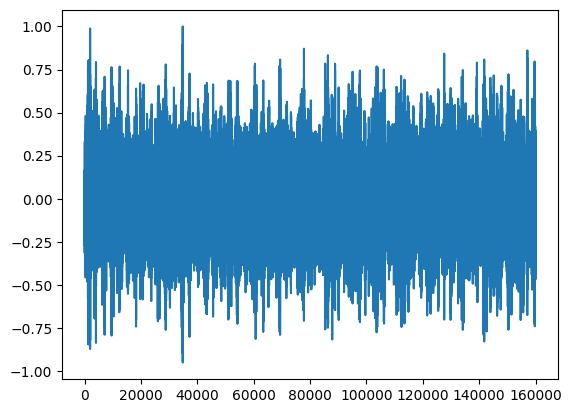

In [143]:
plt.plot(dataset[0][0])

In [136]:
preds = predict(
    model,
    dataset,
    {"activation": "sigmoid"},
    batch_size=BATCH_SIZE,
    device=DEVICE,
    use_fp16=False,
    num_workers=NUM_WORKERS,
)

  0%|          | 0/32 [00:00<?, ?it/s]

In [137]:
if EVAL:
    auc = macro_auc(df["primary_label"].values.tolist(), preds)
    print(f'Fold 0 AUC: {auc:.3f}')

In [138]:
if EVAL:
    from data.preparation import prepare_data
    from data.dataset import WaveDataset

    df_ = prepare_data()
    df_ = df_[df_['fold'] == 0].reset_index(drop=True)
    df = df.merge(df_[["filename", "secondary_labels"]], how="left")
    df['path_ft'] = df['path']
    dataset = WaveDataset(df)

    y, y_s = dataset.get_targets()

    auc = macro_auc(y, preds)
    print(f'Fold 0 AUC:\t {auc:.3f}')
    
    auc = macro_auc(y_s, preds)
    print(f'Fold 0 AUC_s:\t {auc:.3f}')

In [140]:
if not EVAL:
    sub = pd.DataFrame((df["id"] + "_" + df["t_end"].astype(str)).values, columns=['row_id'])
    sub.loc[:, CLASSES] = preds
    sub.to_csv('../output/tmp/submission.csv', index=False)
    display(sub.head())

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,184575141_5,0.003136,0.049863,0.001314,0.000577,0.005707,0.000700,0.001037,0.000318,0.001782,...,0.002820,0.010577,0.003512,0.000988,0.007733,0.028478,0.000782,0.001908,0.001010,0.003753
1,184575141_10,0.003227,0.017401,0.001354,0.000126,0.004946,0.000260,0.000825,0.001015,0.007064,...,0.001455,0.001770,0.005314,0.001473,0.005322,0.017273,0.000923,0.001709,0.000708,0.004105
2,184575141_15,0.002187,0.003410,0.002335,0.000130,0.003637,0.000993,0.000483,0.000662,0.001035,...,0.002875,0.002242,0.004375,0.000494,0.003166,0.036977,0.000469,0.000471,0.000383,0.008104
3,184575141_20,0.000670,0.001348,0.000405,0.000036,0.005254,0.000153,0.000474,0.000423,0.001711,...,0.002651,0.268458,0.001926,0.000558,0.001016,0.009320,0.000560,0.000239,0.001859,0.003413
4,184575141_25,0.001914,0.005158,0.001606,0.000073,0.012566,0.000449,0.002297,0.000386,0.003738,...,0.003126,0.605313,0.004630,0.001112,0.001908,0.008082,0.004034,0.000323,0.006231,0.002068


### EDA

In [ ]:
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)

from util.plots import display_audio

#### Max per class

In [ ]:
max_df = pd.DataFrame(sub.max()).T
max_df = max_df[max_df.columns[1:]].astype(float)
max_df

In [ ]:
sns.distplot(max_df.values[0])
plt.show()

#### Max per recording

In [ ]:
dfg = sub.copy()
dfg['row_id'] = dfg['row_id'].apply(lambda x:x.split('_')[0])
dfg = dfg.groupby('row_id').max()
dfg = dfg.max(1)


pd.DataFrame(dfg[dfg < 0.3]).T

In [ ]:
dfg = sub.copy()

dfg['row_id'] = dfg['row_id'].apply(lambda x:x.split('_')[0])

dfg['max'] = dfg[dfg.columns[1:]].max(1)
dfg_ = dfg[["row_id", "max"]].groupby('row_id').max().reset_index()

In [ ]:
dfg = dfg.drop('max', axis=1).merge(dfg_, how="left")

dfg[CLASSES] = preds / dfg['max'].values[:, None]

# pd.DataFrame(dfg).sort_values("max")

In [ ]:
sns.histplot(dfg.values)
plt.show()

In [ ]:
val = np.load(EXP_FOLDERS[0][0] + "pred_val_0.npy")
sns.histplot(val.max(-1))
plt.show()

#### Single sample

In [ ]:
id_ = "1051136855"
id_ = "1227419659"

df_id = sub[sub["row_id"].apply(lambda x: id_ in x)]

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df_id[df_id.columns[1:]].max(1).values)
plt.grid()
plt.xticks([i for i in range(0, len(df_id), 2)], [f"{i * 5 // 60}'{i * 5 % 60}" for i in range(0, len(df_id), 2)])
plt.show()

In [ ]:
display_audio(DATA_PATH + f"{id_}.ogg", duration=None)


Done ! 